In [8]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
import time
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
# Datele problemei
car_speed = 5 # viteza masinii
turn_rate = 45 # rata de intoarcere
max_distance = 200 # distanta maxima posibila
action_space = [0, 1, 2] # [pastreaza_directia, viraj_stanga, viraj_dreapta]
car_position = np.array([90, 90]) # positia 2D a masinii
location_position = np.array([0, 0]) # positia 2D a locatiei
location_size = 13 # raza locatiei

In [10]:
Q_tabel_model = keras.models.Sequential()
Q_tabel_model.add(keras.layers.Input(batch_input_shape=(1,2))) # Date de intrare
Q_tabel_model.add(keras.layers.Dense(10, activation='relu'))
Q_tabel_model.add(keras.layers.Dense(len(action_space), activation='linear')) # Date de iesire
Q_tabel_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [11]:
class Agent:
  def __init__(self, position, direction, turn_rate, speed):
    self.pos = position.astype(np.float64)
    self.dir = direction
    self.turn_rate = turn_rate
    self.speed = speed
  
  # calculez noua pozitia in functia de actiunea data
  def apply_action(self, action):
    # print(f"Actiune: {action}")
    if action == 2:
      # print("Viraj la dreapta")
      self.dir += self.turn_rate
      if self.dir >= 360:
        self.dir = self.dir - 360
    elif action == 1:
      # print("Viraj la stanga")
      self.dir -= self.turn_rate
      if self.dir < 0:
        self.dir = 360 - self.dir 

    self.pos = self.pos + self.get_vector_direction() * self.speed

  # calculez vectorul de directie
  def get_vector_direction(self):
    return np.array([ np.cos(np.deg2rad(self.dir)) ,  np.sin(np.deg2rad(self.dir))])
  
  # returnez pozitia actuala si vectorul de directie
  def observe(self):
    return self.pos, self.get_vector_direction()

  def __str__(self):
    return f"Pos: {self.pos}, Dir: {self.dir}"

In [12]:
EPISODES = 1200 # numar de episoade pentru care vom face invatarea
EPISODE_ITERATIONS = 50 # Numarul de iteratii maxime al fiecarui episod
LEARNING_RATE = 0.1 # rata de invatare
DISCOUNT = 0.95 # reducerea

# episodul de la care vom incepe sa micsoram rata de explorare
START_EPSILON_DECAYING = 200 
# episodul de la care vom elimina rata de explorare - agentul va fi numai in faza de exploatare
END_EPSILON_DECAYING = int( EPISODES * 0.7 ) 
# rate initiala de explorare
epsilon = 1
# valoarea nu ce care va fi redusa rata de explorare
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

# Date pentru analizat
rewards = [] # recompensele pentru fiecare episod
best_reward = -1000 # recompensa maxima atinsa
best_agent_positions = [] # drumul parcurs de agent in episodul cu cea mai mare recompensa
training_times = []

In [13]:
# calculeaza distanta de la locatia la masina
def compute_distance_from( car_pos ):
  return np.linalg.norm(location_position - car_pos)

# calculeaza unghiul dintre directia masinii si directia masinii catre locatie
def compute_direction_from( car_pos, car_dir ):
  vector_to_location = location_position - car_pos
  value = np.clip(np.dot(car_dir, vector_to_location) / ( np.linalg.norm(car_dir) * np.linalg.norm( vector_to_location) ) ,a_min=1, a_max=-1)
  car_location_angle_difference = np.arccos( value )
  angle = car_location_angle_difference
  return angle

# calculeaza recompensa
def compute_reward_for( state ):
  # verirfic daca am ajuns la destinatie
  if state[0][0] < location_size:
    return 100
  # aplic penalizare pentru ca am iesit in distanta maxima admisa
  elif state[0][0] > max_distance:
    return -100
  # penalizare pentru ca nu am ajuns inca la destinatie
  return -1

# calculeaza starea din observatiile agentului - valori sunt reale
def compute_state_for( observation ):
  return (np.array(
      [compute_distance_from( observation[0] ) / max_distance,
       compute_direction_from( observation[0] ,observation[1] ) / np.pi ])).reshape((1,2))

# calculeaza starea urmatoare si recompensele bazate pe o actiune data catre agent
def compute_future_state_with( action, agent ):
  agent.apply_action( action )
  next_state = compute_state_for( agent.observe() )

  # Calculez recompensa
  reward = compute_reward_for( next_state )

  # Verific daca simularea este gata - masina a ajuns la destinatie sau a depasit distanta maxima
  distance = compute_distance_from(agent.observe()[0])
  done = True if distance < location_size or distance >= max_distance else False

  return next_state, reward, done

Elapsed 4.805 seconds. Eps: 0. Average: 4.805. Time: 13:39:40


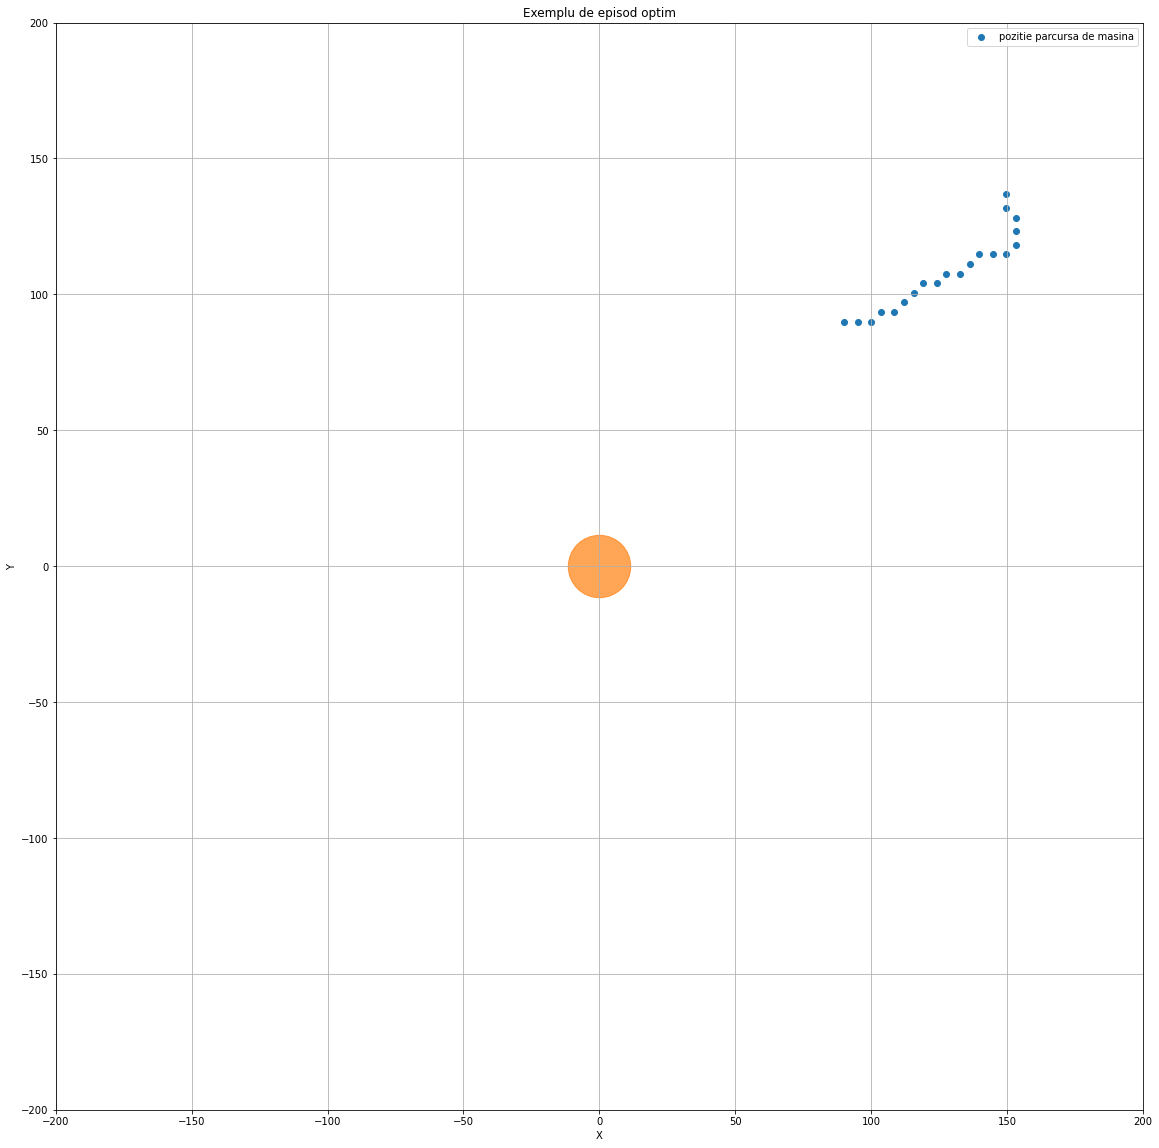

Elapsed 4.293 seconds. Eps: 50. Average: 8.007. Time: 13:46:24
Elapsed 12.100 seconds. Eps: 100. Average: 7.948. Time: 13:52:58
Elapsed 5.208 seconds. Eps: 150. Average: 8.055. Time: 13:59:52
Elapsed 12.820 seconds. Eps: 200. Average: 8.234. Time: 14:07:10
Elapsed 11.252 seconds. Eps: 250. Average: 8.093. Time: 14:13:27
Elapsed 14.249 seconds. Eps: 300. Average: 7.994. Time: 14:19:42


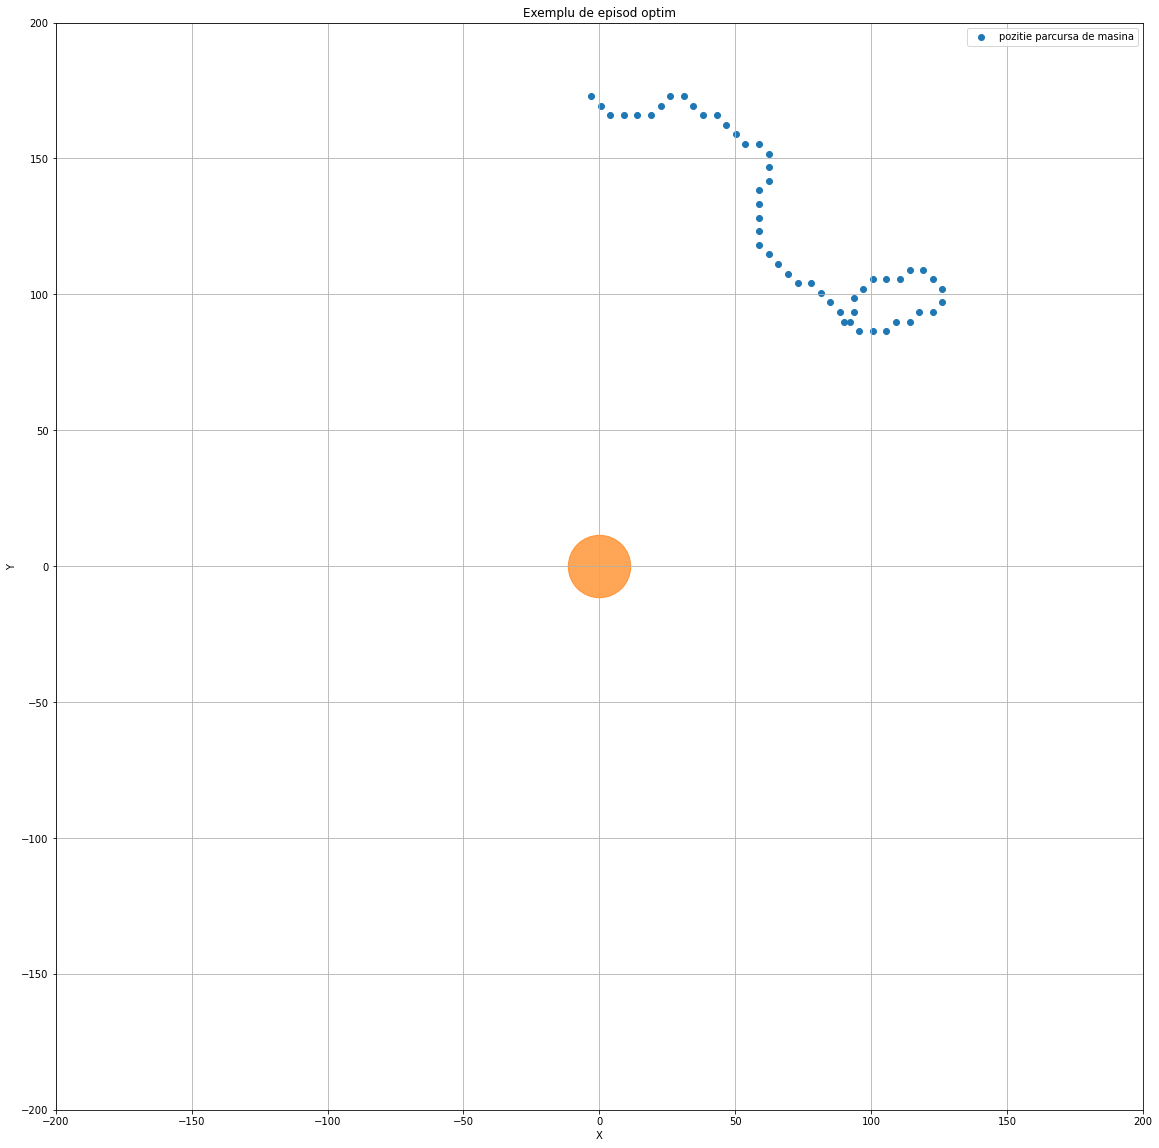

Elapsed 4.622 seconds. Eps: 350. Average: 8.087. Time: 14:26:54
Elapsed 4.847 seconds. Eps: 400. Average: 8.131. Time: 14:33:56
Elapsed 5.762 seconds. Eps: 450. Average: 8.312. Time: 14:42:04
Elapsed 7.507 seconds. Eps: 500. Average: 8.499. Time: 14:50:34
Elapsed 4.671 seconds. Eps: 550. Average: 8.511. Time: 14:57:45
Elapsed 12.824 seconds. Eps: 600. Average: 8.428. Time: 15:04:01


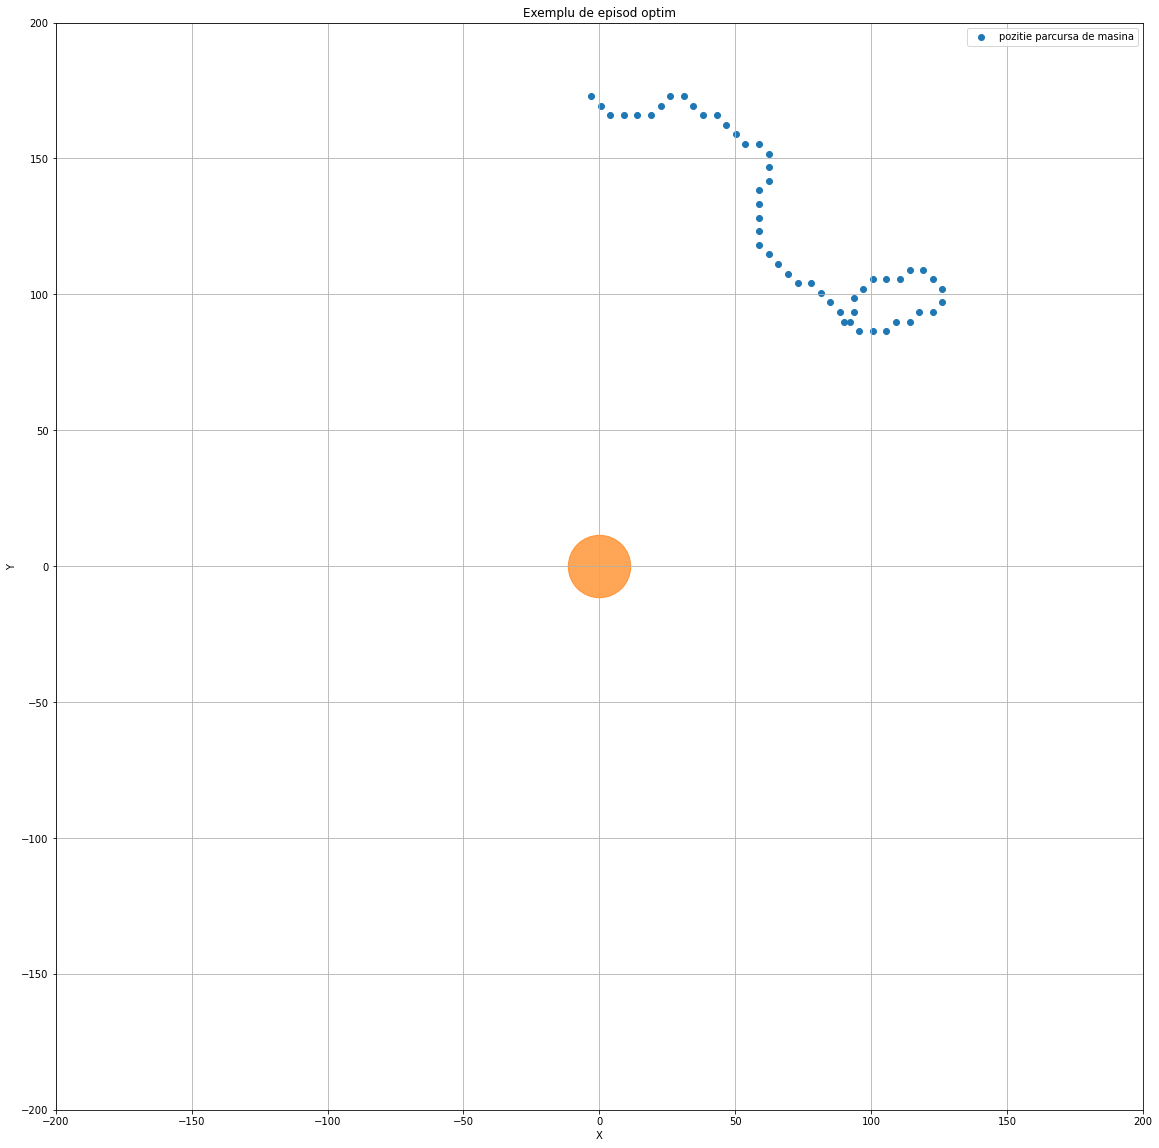

Elapsed 12.949 seconds. Eps: 650. Average: 8.288. Time: 15:09:31
Elapsed 6.165 seconds. Eps: 700. Average: 8.138. Time: 15:14:41


In [ ]:

for eps in range(EPISODES):
  start = time.perf_counter()
  # Initializare variabile pentru episod
  
  # Creez agentul
  agent = Agent(position=np.copy(car_position), direction=0, turn_rate=turn_rate, speed=car_speed)

  # Lista care va contine toate pozitile din iteratia curenta
  agent_positions = [agent.pos]

  # Recompensele/penalizarile castigate in episod
  episode_reward = 0
  # Numarul iteratiei curente
  episode_iteration = 0

  # calculez starea actuala in baza obeservatiei date de agent
  current_state = compute_state_for( agent.observe() )
  # print(current_state)
#   print(Q_tabel_model.predict(current_state))
  
  # variabila care marcheaza sfarsitul episodului
  done = False

  while not done:

    # Verificam daca nu suntem in stadiul de explorare
    if np.random.random() > epsilon:
      # Alegem cea mai buna actiune
      action = np.argmax( Q_tabel_model.predict(current_state) )
    else:
      # Alegem o actiune aletoare
      action = np.random.randint(0, 3)
   
    # calculez starea urmatoare conform actiunii luate
    next_state, reward, done = compute_future_state_with( action, agent )
    # print(Q_tabel_model.predict(current_state))
    current_Q_value =  Q_tabel_model.predict(current_state)[0][action]
    max_future_Q_value = np.max(Q_tabel_model.predict(next_state)[0])
    new_Q = reward + DISCOUNT * max_future_Q_value
    
    target_Q_value =  Q_tabel_model.predict(current_state)
    target_Q_value[0][action] = new_Q
    
#     print(action)
#     print(max_future_Q_value)
#     print(new_Q)
#     print(target_Q_value)
    
    Q_tabel_model.fit(
        current_state,
        target_Q_value.reshape(-1, 3),
        epochs=1,
        verbose=0
    )
    
    current_state = next_state
    
   
    # adun recompensa din iteratia curenta
    episode_reward += reward
    # salvez pozitia din iteratia curenta
    agent_positions.append(agent.pos)
    # trec la iteratia urmatore
    episode_iteration += 1

    if episode_iteration > EPISODE_ITERATIONS:
      break

  # daca agentul a stabilit o recompensa mai buna
  # salvez aceste date pentru vizualizare
  if episode_reward > best_reward:
    best_reward = episode_reward
    best_agent_positions = copy.deepcopy(agent_positions)
    
  elapsed = time.perf_counter() - start
  training_times.append(elapsed)
    
  if eps % 50 == 0:
    elapsed = time.perf_counter() - start
    print('Elapsed %.3f seconds. Eps: %d. Average: %.03f. Time: %s' % (elapsed, eps, np.average(training_times), time.strftime("%H:%M:%S", time.localtime())))
  if eps % 300 == 0:
    fig, (position_plot) = plt.subplots(1)
    fig.set_figheight(20)
    fig.set_figwidth(20)

    xs = []
    ys = []
    for pos in best_agent_positions:
      x, y = pos
      xs.append(x)
      ys.append(y) 

    position_plot.scatter(xs, ys, label="pozitie parcursa de masina")
    position_plot.scatter(location_position[0], location_position[1], s=location_size * 300, alpha=0.7)
    position_plot.axis([-max_distance, max_distance, -max_distance, max_distance])
    position_plot.set_aspect('equal', 'box')
    position_plot.grid()
    position_plot.set_xlabel('X')
    position_plot.set_ylabel('Y')
    position_plot.legend()
    position_plot.set_title('Exemplu de episod optim')
    plt.show()
    


  # veriric daca trebuie sa reduc rata de explorare
  if END_EPSILON_DECAYING >= eps >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
  # salvez recompensa pe episodului
  rewards.append( episode_reward )
    

In [ ]:
Q_tabel_model.summary()

In [ ]:
# VIZUALIZARE
fig, (reward_plot) = plt.subplots(1)

fig.set_figwidth(15)

reward_plot.plot(rewards)
reward_plot.set_xlabel('Episod')
reward_plot.set_ylabel('Recompensa')
reward_plot.set_title('Evolutia recompenselor de-a lungul episoadelor')
plt.show()

In [ ]:
fig, (position_plot) = plt.subplots(1)
fig.set_figheight(20)
fig.set_figwidth(20)

xs = []
ys = []
for pos in best_agent_positions:
  x, y = pos
  xs.append(x)
  ys.append(y) 

position_plot.scatter(xs, ys, label="pozitie parcursa de masina")
position_plot.scatter(location_position[0], location_position[1], s=location_size * 300, alpha=0.7)
position_plot.axis([-max_distance, max_distance, -max_distance, max_distance])
position_plot.set_aspect('equal', 'box')
position_plot.grid()
position_plot.set_xlabel('X')
position_plot.set_ylabel('Y')
position_plot.legend()
position_plot.set_title('Exemplu de episod optim')
plt.show()

In [ ]:
plt.plot(training_times)
plt.show()